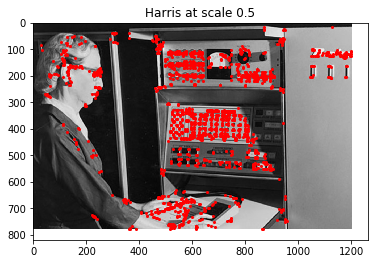

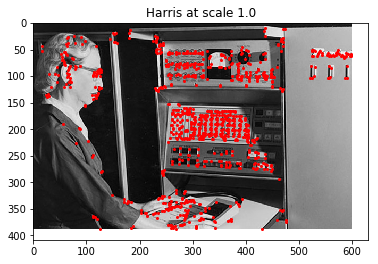

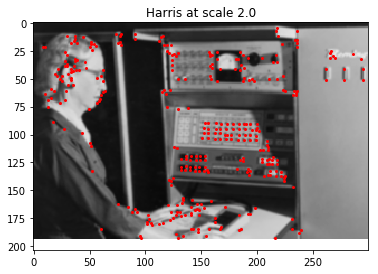

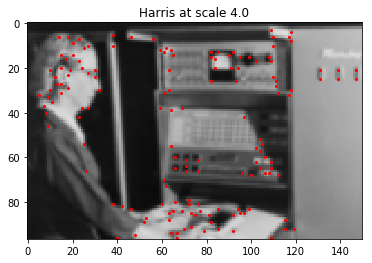

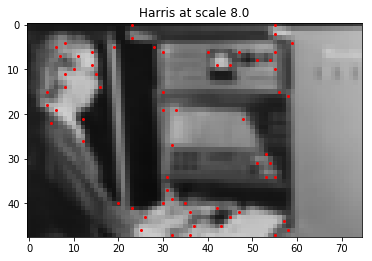

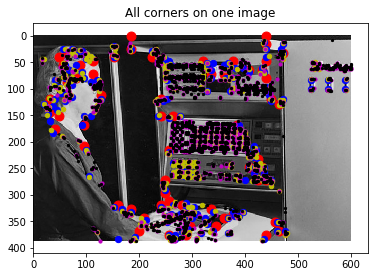

In [0]:
#David Fouhey
#Harris detection 
#UMich EECS 442 Fall 2019

from math import *
import numpy as np
import pdb
import os
import cv2
import scipy.signal, scipy.misc
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt

def ensuregrace():
  #ensure a copy of the grace hopper image is in the current directory
  if not os.path.exists("grace_600.png"):
    !wget http://web.eecs.umich.edu/~fouhey/misc/grace_600.png
    #If local, run this instead
    #os.system("wget http://web.eecs.umich.edu/~fouhey/misc/grace_600.png")

def gdilate(I,sz):
  #dilation sets each pixel to the maximum value in a given neighborhood
  return ndimage.grey_dilation(I,size=(sz,sz),structure=np.zeros((sz,sz)))

if __name__ == "__main__":
  #Basically an extended version of the opencv harris documentation / tutorial
  
  ensuregrace()
  #load the image
  #note that we're not converting to float
  grace = np.array(Image.open("grace_600.png").convert('L'))
  
  option = "multiscaleharris"
  
  if option == "harrisnms":
    #images are tiny otherwise
    plt.rcParams['figure.figsize'] = [15, 15]
    
    corner = cv2.cornerHarris(grace,2,3,0.04)

    #do non-max suppression; check if we're not the maximum in a 3x3 neighborhood
    cornerDilate = gdilate(corner,3)
    cornerSuppress = corner < cornerDilate

    cornerMask = corner>0.01*corner.max()
    graceView = np.dstack([grace]*3)
    graceView[cornerMask] = [255,0,0]
    plt.figure()
    plt.imshow(graceView)

    cornerNMSMask = cornerMask.copy()
    cornerNMSMask[cornerSuppress] = False

    graceView = np.dstack([grace]*3)
    graceView[cornerNMSMask] = [255,0,0]
    plt.figure()
    plt.imshow(graceView)
  
  elif option == "multiscaleharris":
    #images are tiny otherwise
    plt.rcParams['figure.figsize'] = [6, 6]
    
    
    colors = ['k','m','y','b','r']
    scales = [0.5,1,2,4,8]
    wheres = []
    
    for sc in scales:
      h, w = grace.shape

      #use grace or a blurred version (before downsampling) 
      graceUse = grace if sc <= 1 else cv2.GaussianBlur(grace,(sc*4+1,sc*4+1),0)
      
      #resample
      graceScale = cv2.resize(graceUse,\
          (int(w/float(sc)),int(h/float(sc))),\
          cv2.INTER_AREA if sc > 1 else cv2.INTER_LINEAR)
      
      #compute the corners and suppress non-max
      corner = cv2.cornerHarris(graceScale,2,3,0.04)
      cornerDilate = gdilate(corner,3)
      cornerMask = (corner > 0.01*corner.max())
      cornerMask[corner < cornerDilate] = 0
      
      #compute where and add them to list
      y, x = np.where(cornerMask)
      wheres.append((y*sc,x*sc))
      
      #show harris corners
      plt.figure()
      plt.imshow(graceScale,cmap='gray',vmin=0,vmax=255)
      plt.scatter(x,y,4,'r')
      plt.title("Harris at scale %.1f" % sc)
      
    #show all harris corners      
    plt.figure()
    plt.imshow(grace,cmap='gray',vmin=0,vmax=255)
    for sci in range(len(scales)-1,-1,-1):      
      plt.scatter(wheres[sci][1],wheres[sci][0],scales[sci]*10,colors[sci])
    plt.title("All corners on one image")
      
  
  
    
  
  
 

  
